# 주제 : LSTM을 활용해 주가 예측 모델 구현하기

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## Step 1. 데이터 불러오기 및 EDA

### 문제 01. 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

### 문제 02. FinanceDataReader import

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
!pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

### 문제 03. 삼성전자 데이터 불러오기

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

### 문제 04. 삼성전자 데이터 EDA

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-12,90300,91400,87800,90600,48682416,-0.004396
2021-01-13,89800,91200,89100,89700,36068848,-0.009934
2021-01-14,88700,90000,88700,89700,26393970,0.000000
2021-01-15,89800,91800,88000,88000,33431809,-0.018952
2021-01-18,86600,87300,84100,85000,42656806,-0.034091


**미국 주식 데이터**도 가져올 수 있습니다.

### 문제 05. 애플 데이터 불러오기

In [6]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

### 문제 06. 애플 데이터 EDA

In [7]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-01-11,128.98,128.99,130.12,128.59,100620000.0,-0.0232
2021-01-12,128.80,128.40,129.66,126.89,91950000.0,-0.0014
2021-01-13,130.89,128.65,131.43,128.56,88640000.0,0.0162
2021-01-14,128.91,130.79,130.98,128.78,90220000.0,-0.0151
2021-01-15,127.14,128.78,130.22,127.00,111600000.0,-0.0137


### 문제 07. 특정 시점(2017년) 이후 데이터 불러오기

In [8]:
# Apple(AAPL), 2017년
apple = fdr.DataReader('AAPL', '2017')

In [9]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


### 문제 08. 날짜를 지정하여 특정 범위(40년간) 데이터 불러오기

In [10]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [11]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.85,1.85,1.88,1.84,3770000.0,-0.0160
1980-03-19,1.87,1.87,1.88,1.85,1560000.0,0.0108
1980-03-20,1.88,1.88,1.90,1.87,1450000.0,0.0053
1980-03-21,1.80,1.80,1.87,1.78,5020000.0,-0.0426
1980-03-24,1.73,1.73,1.77,1.68,3330000.0,-0.0389


In [12]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


### 문제 09. '금'과 '달러' 데이터도 가져올 수 있습니다. 두 데이터를 불러와 head를 출력해보세요.

*[GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader) 참고

In [13]:
gold = fdr.DataReader('ZG') # 금 선물 (ICE)
gold.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-01-02,575.5,562.5,577.0,558.0,7260.0,0.0785
1980-01-03,625.0,627.0,640.0,603.0,20750.0,0.0860
1980-01-04,603.6,609.5,621.0,573.0,2660.0,-0.0342
1980-01-07,627.0,629.0,635.0,611.0,3000.0,0.0388
1980-01-08,602.5,611.5,619.0,600.0,750.0,-0.0391


In [14]:
usdkrw = fdr.DataReader('USD/KRW', '1995-01-01') 
usdkrw.head()

,Close,Open,High,Low,Change
Date,,,,,
1995-01-02,788.50,788.50,788.50,788.50,0.0000
1995-01-03,788.65,788.05,788.85,787.55,0.0002
1995-01-04,789.95,788.65,790.05,788.45,0.0016
1995-01-05,789.90,789.80,790.20,789.30,-0.0001
1995-01-06,791.55,789.75,791.65,789.65,0.0021


### 문제 10. 주식 코드를 활용해 데이터 불러오기

In [15]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [16]:
# fdr 라이브러리를 활용해 삼성전자 데이터를 불러오세요 
stock = fdr.DataReader(STOCK_CODE)

In [17]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-02-05,949,960,914,927,264930,NaN
1997-02-06,924,935,898,930,140231,0.003236
1997-02-10,930,958,924,959,105570,0.031183
1997-02-11,960,972,942,973,130180,0.014599
1997-02-12,967,1022,964,1001,241110,0.028777


In [18]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-12,90300,91400,87800,90600,48682416,-0.004396
2021-01-13,89800,91200,89100,89700,36068848,-0.009934
2021-01-14,88700,90000,88700,89700,26393970,0.000000
2021-01-15,89800,91800,88000,88000,33431809,-0.018952
2021-01-18,86600,87300,84100,85000,42656806,-0.034091


In [19]:
# 인덱스를 확인해보세요.
stock.index

DatetimeIndex(['1997-02-05', '1997-02-06', '1997-02-10', '1997-02-11',
               '1997-02-12', '1997-02-13', '1997-02-14', '1997-02-15',
               '1997-02-17', '1997-02-18',
               ...
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
               '2021-01-15', '2021-01-18'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

## Step 2. 시계열 데이터 시각화


### 문제 11. 인덱스가 `DatetimeIndex`로 정의되어 있다면, 연도, 월, 일을 쪼갤 수 있습니다. 데이터를 분리해주세요.

In [20]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [21]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-02-05,949,960,914,927,264930,NaN,1997,2,5
1997-02-06,924,935,898,930,140231,0.003236,1997,2,6
1997-02-10,930,958,924,959,105570,0.031183,1997,2,10
1997-02-11,960,972,942,973,130180,0.014599,1997,2,11
1997-02-12,967,1022,964,1001,241110,0.028777,1997,2,12


### 문제 12. 연도별, 월별 피봇테이블을 각각 구현해보세요.

In [23]:
stock.groupby(['Year', 'Month']).mean()

Open          High  ...    Change        Day
Year Month                              ...                     
1997 2        991.210526   1017.736842  ...  0.006394  17.526316
     3        992.800000   1008.560000  ...  0.001539  16.600000
     4       1097.080000   1110.920000  ...  0.000641  15.760000
     5       1115.208333   1128.125000  ...  0.004537  17.416667
     6       1225.916667   1245.125000  ...  0.002355  16.000000
...                  ...           ...  ...       ...        ...
2020 9      58176.190476  58761.904762  ...  0.003694  14.619048
     10     59836.842105  60242.105263  ... -0.001401  17.947368
     11     63090.476190  64019.047619  ...  0.008034  15.238095
     12     73066.666667  74233.333333  ...  0.009441  14.857143
2021 1      86109.090909  88681.818182  ...  0.004760  10.272727

[288 rows x 7 columns]

### 문제 13. matplotlib을 활용해 시간에 따른 주식 가격 시계열 그래프를 그려보세요.

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


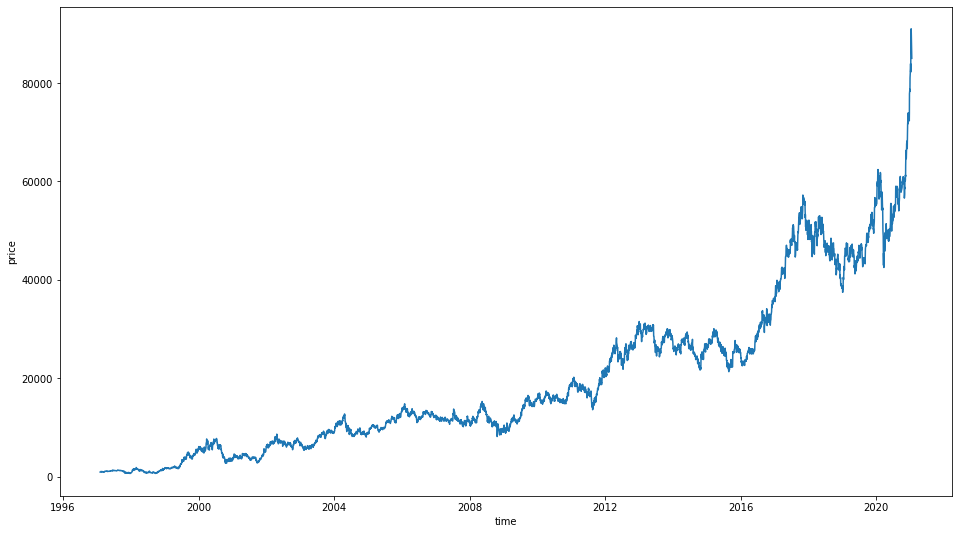

In [24]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

### 문제 14. subplots를 활용해 그래프 4개(2,2)를 동시에 그려보세요.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


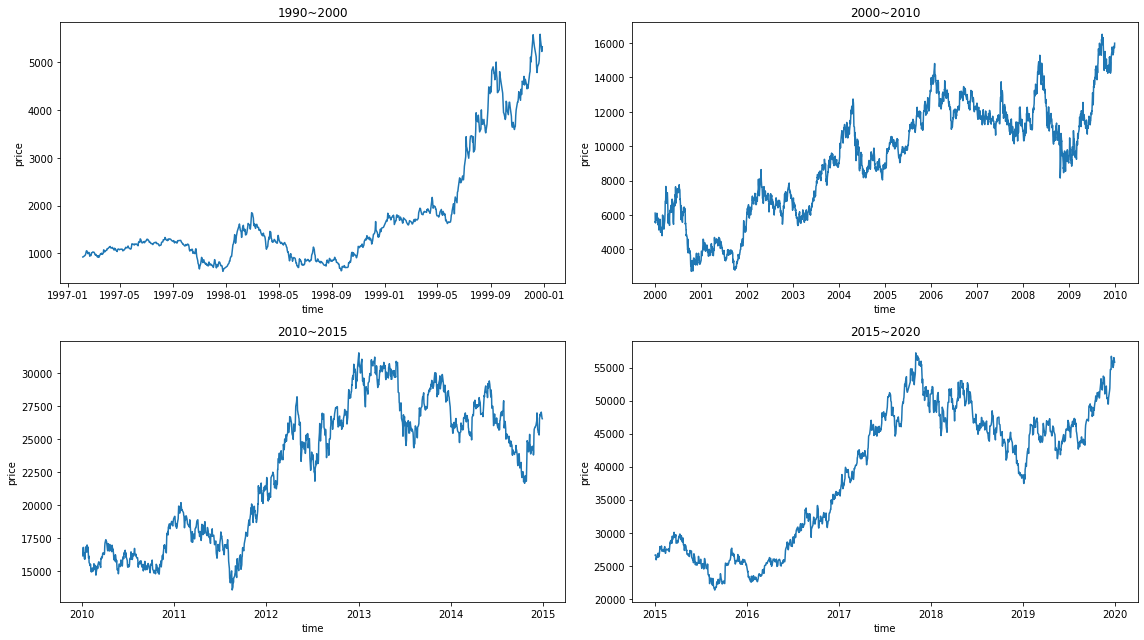

In [25]:
# 1990~2000, 2000~2010, 2010~2015, 2015~2020
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## Step 3. 시계열 데이터의 전처리

### 문제 15. MinMaxScaler를 활요해 데이터 전처리를 수행합니다.

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.01050941, 0.00991736, 0.01021229, 0.00331958, 0.00293369],
       [0.01023256, 0.00965909, 0.01003352, 0.00335277, 0.00155284],
       [0.010299  , 0.00989669, 0.01032402, 0.00367366, 0.00116902],
       ...,
       [0.98228128, 0.92975207, 0.99106145, 0.98561517, 0.29227203],
       [0.9944629 , 0.94834711, 0.98324022, 0.96680424, 0.37020512],
       [0.95902547, 0.9018595 , 0.9396648 , 0.93360849, 0.47235757]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [27]:
# 아래 코드는 그대로 실행해주세요.
df = pd.DataFrame(scaled, columns=scale_cols)

### 문제 16. 모델 학습을 위해 train 데이터와 test 데이터로 분할해주세요.

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Close 컬럼이 예측할 데이터입니다.
# test_size는 0.2, random_state는 0으로 지정해주세요.
# shuffle을 수행하지 않습니다.
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

### 문제 17. train 데이터와 test 데이터의 shape을 각각 살펴봅니다.

In [30]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [31]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [32]:
x_train

,Open,High,Low,Volume
0,0.010509,0.009917,0.010212,0.002934
1,0.010233,0.009659,0.010034,0.001553
2,0.010299,0.009897,0.010324,0.001169
3,0.010631,0.010041,0.010525,0.001442
4,0.010709,0.010558,0.010771,0.002670
...,...,...,...,...
4795,0.261130,0.245661,0.262123,0.001635
4796,0.260908,0.243595,0.259441,0.001556
4797,0.259579,0.245248,0.261899,0.001480
4798,0.261351,0.245248,0.261899,0.001964


### 문제 18. TensroFlow Dataset을 활용해 시퀀스 데이터셋을 함수로 구현해주세요

In [33]:
import tensorflow as tf

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

## Step 4. 모델 구현하기

### 문제 19. Hyperparameter를 정의하고 데이터에 적용해주세요.

In [35]:
# 아래 코드는 그대로 실행해주세요.
WINDOW_SIZE=20
BATCH_SIZE=32

In [36]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# WINDOW_SIZE와 BATCH_SIZE를 각 데이터셋에 적용해주세요.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [37]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다. 그대로 실행해보고, 데이터의 shape을 살펴보세요.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


### 문제 20. Sequential 모델을 구현합니다. 

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성합니다. filters는 32로, kernel_size는 5로 지정해주세요.
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM과 Dense 레이러를 사용해주세요. 활성함수는 각각 tanh와 relu로 지정합니다.
    LSTM(16, activation='relu'),
    Dense(16, activation="relu"),
    Dense(1),
])

### 문제 21. 모델을 Compile합니다. loss는 Huber 함수를 사용하고 optimizer는 Adam을 사용해주세요.

In [39]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [40]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [41]:
# callbacks로 앞에서 구현한 earlystopping과 checkpoint를 지정해주세요.
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
150/150 [==============================] - 11s 40ms/step - loss: 2.1124e-04 - mse: 4.2248e-04 - val_loss: 0.0031 - val_mse: 0.0062

Epoch 00001: val_loss improved from inf to 0.00308, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
150/150 [==============================] - 6s 38ms/step - loss: 1.9897e-05 - mse: 3.9794e-05 - val_loss: 0.0011 - val_mse: 0.0021

Epoch 00002: val_loss improved from 0.00308 to 0.00106, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
150/150 [==============================] - 6s 38ms/step - loss: 1.2729e-05 - mse: 2.5457e-05 - val_loss: 0.0012 - val_mse: 0.0025

Epoch 00003: val_loss did not improve from 0.00106
Epoch 4/50
150/150 [==============================] - 6s 38ms/step - loss: 1.1983e-05 - mse: 2.3966e-05 - val_loss: 9.2039e-04 - val_mse: 0.0018

Epoch 00004: val_loss improved from 0.00106 to 0.00092, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
150/150 [==============================] - 6s 37ms/step - loss: 1.1973e-05 - mse: 2.394

## Step 5. 모델을 활용한 예측 및 결과 시각화

### 문제 24. 저장한 ModelCheckpoint 를 불러옵니다.

In [46]:
model.load_weights(filename)

### 문제 25. `test_data`를 활용하여 예측을 수행합니다.

In [47]:
pred = model.predict(test_data)

In [48]:
pred.shape

(1180, 1)

### 문제 26. matplotlib을 활용해 예측 데이터를 시각화해주세요.

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

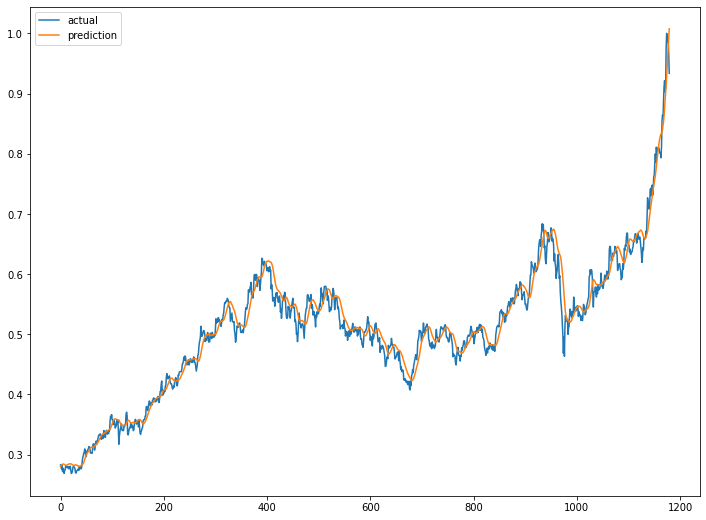

In [49]:
# 20일치의 데이터로 21일치를 예측하므로 test_data 사용시 이전 20일은 예측하지 않습니다.
# 따라서 y_test 데이터에 [20:]로 슬라이싱해주세요.
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()